In [30]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(r"C:\Users\usuar\Desktop\The_Bridge\EDA_F1_Analysis\src\utils")
from funciones_eda import *
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import mannwhitneyu

## Extracción y limpieza de los datos
### Extracción de los datos

Primero realizaremos una extracción y una limpieza de los datos para poder trabajar con ellos más cómodamente. Los datos han sido obtenido de:
- **Kaggle**
- **Páginas web**

Estos primeros datos contienen los campeones tanto del campeonato de pilotos como el de equipos que han habido en los 74 campeonatos de la F1. Como los equipos campeones están separados de los pilotos campeones, juntaremos los datos relevantes de la tabla de equipos ganadores con la de pilotos.

In [17]:
# Equipos ganadores del campeonato. Creamos este df para saber cual es el equipo que
# ganó el mundial y juntarlo con el de pilotos ganadores.
url = "https://es.wikipedia.org/wiki/Campeonato_Mundial_de_Constructores_de_F%C3%B3rmula_1"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find_all('table', {'class': 'wikitable sortable'})[0]
rows = table.find_all('tr')
headers = [th.get_text(strip=True) for th in rows[0].find_all('th')]

data = []
for row in rows[1:]:
    cols = row.find_all('td')
    if len(cols) == 12:
        cols = [col.get_text(strip=True) for col in cols]
        data.append(cols)

df_equipos_ganadores = pd.DataFrame(data, columns=headers)
print(df_equipos_ganadores.info())
df_equipos_ganadores.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Año            67 non-null     object
 1   Constructor    67 non-null     object
 2   Motor          67 non-null     object
 3   Chasis         67 non-null     object
 4   Neu.           67 non-null     object
 5   Pilotos[t 1]​  67 non-null     object
 6   PP.            67 non-null     object
 7   Vic.           67 non-null     object
 8   Pod.           67 non-null     object
 9   VR.            67 non-null     object
 10  Pun.[t 2]​     67 non-null     object
 11  Mar.           67 non-null     object
dtypes: object(12)
memory usage: 6.4+ KB
None


,Año,Constructor,Motor,Chasis,Neu.,Pilotos[t 1]​,PP.,Vic.,Pod.,VR.,Pun.[t 2]​,Mar.
0,1958,Vanwall,Vanwall,VW 5,D,Stirling MossTony Brooks,5,6,9,3,48,8
1,1959,Cooper,Climax,T51,D,Jack Brabham*Stirling MossBruce McLaren,5,5,13,5,40,8
2,1960,Cooper,Climax,T51T53,D,Jack Brabham*Bruce McLaren,4,6,14,5,48,14
3,1961,Ferrari,Ferrari,156,D,Phil Hill*Wolfgang von Trips,6,5,14,5,45,10
4,1962,BRM,BRM,P57,D,Graham Hill*,1,4,8,3,42,6


Ahora extraemos los datos de los pilotos ganadores.

In [18]:
# Pilotos ganadores del campeonato.
url = "https://en.wikipedia.org/wiki/List_of_Formula_One_World_Drivers%27_Champions"

response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")
tabla = soup.find("table", {"class": "wikitable sortable"})
filas = tabla.find_all("tr")
datos = []

for fila in filas[1:]:  # Ignora la primera fila que es el encabezado
    cols = fila.find_all("td")
    
    if len(cols) == 16:
        year = cols[0].text.strip()
        driver = cols[1].text.strip()
        age = cols[2].text.strip()
        team = cols[3].text.strip()
        engine = cols[4].text.strip()
        tyres = cols[5].text.strip()
        pole = cols[6].text.strip()
        wins = cols[7].text.strip()
        podiums = cols[8].text.strip()
        fastest_laps = cols[9].text.strip()
        points = cols[10].text.strip()
        percent_points = cols[11].text.strip()
        clinched = cols[12].text.strip()
        rounds_remaining = cols[13].text.strip()
        margin = cols[14].text.strip()
        percent_margin = cols[15].text.strip()
        
        datos.append([year, driver, age, team, engine, tyres, pole, wins, 
                     podiums, fastest_laps, points, percent_points, clinched, 
                     rounds_remaining, margin, percent_margin])

df_temporadas_f1 = pd.DataFrame(datos, columns=[
    "year", "Driver", "Age", "Team", "Engine", "Tyres", "Pole", 
    "Wins", "Podiums", "Fastest Laps", "Points", "% Points", "Clinched", 
    "# of Rounds Remaining", "Margin", "% Margin"
])

print(df_temporadas_f1.info())
df_temporadas_f1.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   year                   75 non-null     object
 1   Driver                 75 non-null     object
 2   Age                    75 non-null     object
 3   Team                   75 non-null     object
 4   Engine                 75 non-null     object
 5   Tyres                  75 non-null     object
 6   Pole                   75 non-null     object
 7   Wins                   75 non-null     object
 8   Podiums                75 non-null     object
 9   Fastest Laps           75 non-null     object
 10  Points                 75 non-null     object
 11  % Points               75 non-null     object
 12  Clinched               75 non-null     object
 13  # of Rounds Remaining  75 non-null     object
 14  Margin                 75 non-null     object
 15  % Margin               75

,year,Driver,Age,Team,Engine,Tyres,Pole,Wins,Podiums,Fastest Laps,Points,% Points,Clinched,# of Rounds Remaining,Margin,% Margin
0,1950,Giuseppe Farina[21],44,Alfa Romeo,Alfa Romeo,P,2,3,3,3,30,83.333 (47.619),Round 7 of 7,0,3,10.000
1,1951,Juan Manuel Fangio[22],40,Alfa Romeo,Alfa Romeo,P,4,3,5,5,31,86.111 (51.389),Round 8 of 8,0,6,19.355
2,1952[a],Alberto Ascari[24],34,Ferrari,Ferrari,F P,5,6,6,6,36,100.000 (74.306),Round 6 of 8,2,12,33.333
3,1953[a],Alberto Ascari[24],35,Ferrari,Ferrari,P,6,5,5,4,34.5,95.833 (57.407),Round 8 of 9,1,6.5,18.841
4,1954,Juan Manuel Fangio[22],43,Maserati[b],Maserati,P,5,6,7,3,42,93.333 (70.547),Round 7 of 9,2,16.857,40.136


### Limpieza de los datos

- Podemos ver que la columna `Driver` contiene además del nombre del piloto, un número entre corchetes. Vamos a eliminar tanto el corchete como el contenido del mismo ya que no son relevantes. 
- La columna `Tyres` tiene celdas que contienen más de un valor. Eliminaremos un valor de tipo de rueda para quedarnos solo con uno.
- Todas las variables tienen valores de tipo `object`, pero algunas variables nos interesan que estén en tipo int o float como por ejemplo `Age, Pole, Wins, Podiums`. Vamos a realizar ese cambio de tipo.

In [19]:
# Eliminar los corchetes y contenido de las columnas que tienen corchetes para limpiar los datos.
for column in df_temporadas_f1.columns:
    for index in range(len(df_temporadas_f1)):
        df_temporadas_f1.at[index, column] = re.sub(r'\[.*?\]', '', str(df_temporadas_f1.at[index, column]))

# Convertir los datos de la variable "Tyres" en un solo valor para poder analizarlo mejor.
df_temporadas_f1["year"] = pd.to_numeric(df_temporadas_f1["year"])
df_temporadas_f1.loc[df_temporadas_f1["Tyres"] == "F P", "Tyres"] = "F"
df_temporadas_f1.loc[df_temporadas_f1["Tyres"] == "M G", "Tyres"] = "G"

# Convertir las variables númericas en tipo "int" y "float".
columnas_cambio_tipo = ["Age","Pole","Wins","Podiums","Fastest Laps","# of Rounds Remaining"]
df_temporadas_f1[columnas_cambio_tipo] = df_temporadas_f1[columnas_cambio_tipo].astype(int)
df_temporadas_f1["Points"] = df_temporadas_f1["Points"].astype(float)

print(df_temporadas_f1.info())
df_temporadas_f1.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   75 non-null     int64  
 1   Driver                 75 non-null     object 
 2   Age                    75 non-null     int64  
 3   Team                   75 non-null     object 
 4   Engine                 75 non-null     object 
 5   Tyres                  75 non-null     object 
 6   Pole                   75 non-null     int64  
 7   Wins                   75 non-null     int64  
 8   Podiums                75 non-null     int64  
 9   Fastest Laps           75 non-null     int64  
 10  Points                 75 non-null     float64
 11  % Points               75 non-null     object 
 12  Clinched               75 non-null     object 
 13  # of Rounds Remaining  75 non-null     int64  
 14  Margin                 75 non-null     object 
 15  % Margin

,year,Driver,Age,Team,Engine,Tyres,Pole,Wins,Podiums,Fastest Laps,Points,% Points,Clinched,# of Rounds Remaining,Margin,% Margin
0,1950,Giuseppe Farina,44,Alfa Romeo,Alfa Romeo,P,2,3,3,3,30.0,83.333 (47.619),Round 7 of 7,0,3,10.000
1,1951,Juan Manuel Fangio,40,Alfa Romeo,Alfa Romeo,P,4,3,5,5,31.0,86.111 (51.389),Round 8 of 8,0,6,19.355
2,1952,Alberto Ascari,34,Ferrari,Ferrari,F,5,6,6,6,36.0,100.000 (74.306),Round 6 of 8,2,12,33.333
3,1953,Alberto Ascari,35,Ferrari,Ferrari,P,6,5,5,4,34.5,95.833 (57.407),Round 8 of 9,1,6.5,18.841
4,1954,Juan Manuel Fangio,43,Maserati,Maserati,P,5,6,7,3,42.0,93.333 (70.547),Round 7 of 9,2,16.857,40.136


Una vez tenemos los dos dataframes cargados correctamente, los juntamos para tener los datos necesarios en uno solo y poder manipularlo fácilmente a la hora de realizar el análisis. Tan solo cogeremos la columna `Constructor` para juntarla con los datos de los pilotos.
Como el premio a equipo ganador del campeonato se comenzó a dar a partir de 1958, desde el año 1950 hasta 1958 los valores que son nulos los cambiaremos por `Not awarded`.

In [20]:
# Añadir filas por encima del df de equipos ganadores para poder juntarlo con el otro y cuadre el número de filas.
diferencia = 75 - len(df_equipos_ganadores)

# Si faltan filas, añadir filas vacías solo al principio.
if diferencia > 0:
    filas_extra = pd.DataFrame( index=range(diferencia), columns=df_equipos_ganadores.columns)
    df_equipos_ganadores = pd.concat([filas_extra, df_equipos_ganadores], ignore_index=True)

df_temporadas_f1["Team_winner"] = df_equipos_ganadores["Constructor"]
# Sustituir los nulos por "Not awarded".
df_temporadas_f1["Team_winner"] = df_temporadas_f1["Team_winner"].fillna("Not awarded")

df_temporadas_f1.head(5)

,year,Driver,Age,Team,Engine,Tyres,Pole,Wins,Podiums,Fastest Laps,Points,% Points,Clinched,# of Rounds Remaining,Margin,% Margin,Team_winner
0,1950,Giuseppe Farina,44,Alfa Romeo,Alfa Romeo,P,2,3,3,3,30.0,83.333 (47.619),Round 7 of 7,0,3,10.000,Not awarded
1,1951,Juan Manuel Fangio,40,Alfa Romeo,Alfa Romeo,P,4,3,5,5,31.0,86.111 (51.389),Round 8 of 8,0,6,19.355,Not awarded
2,1952,Alberto Ascari,34,Ferrari,Ferrari,F,5,6,6,6,36.0,100.000 (74.306),Round 6 of 8,2,12,33.333,Not awarded
3,1953,Alberto Ascari,35,Ferrari,Ferrari,P,6,5,5,4,34.5,95.833 (57.407),Round 8 of 9,1,6.5,18.841,Not awarded
4,1954,Juan Manuel Fangio,43,Maserati,Maserati,P,5,6,7,3,42.0,93.333 (70.547),Round 7 of 9,2,16.857,40.136,Not awarded


Tenemos el dataframe de las temporadas con los datos necesarios, ahora realizamos la carga y limpieza de los datos para el dataframe de todas las `carreras`. 
El proceso será distinto al realizado anteriormente ya que los datos de las carreras se encuentran en **Kaggle**.

In [21]:
# Extracción de los datos para crear el df.
circuits = pd.read_csv("./data/f1_data/circuits.csv")
constructors = pd.read_csv("./data/f1_data/constructors.csv")
constructor_results = pd.read_csv("./data/f1_data/constructor_results.csv")
constructor_standings = pd.read_csv("./data/f1_data/constructor_standings.csv")
drivers = pd.read_csv("./data/f1_data/drivers.csv")
driver_standings = pd.read_csv("./data/f1_data/driver_standings.csv")
lap_times = pd.read_csv("./data/f1_data/lap_times.csv")
pit_stops = pd.read_csv("./data/f1_data/pit_stops.csv")
qualifying = pd.read_csv("./data/f1_data/qualifying.csv")
races = pd.read_csv("./data/f1_data/races.csv")
results = pd.read_csv("./data/f1_data/results.csv")
seasons = pd.read_csv("./data/f1_data/seasons.csv")
status = pd.read_csv("./data/f1_data/status.csv")

df_combinado = pd.merge(results, races, on='raceId', how='left')

df_combinado = pd.merge(df_combinado, drivers, on='driverId', how='left')

if 'constructorId' in constructors.columns:
    df_combinado = pd.merge(df_combinado, constructors, on='constructorId', how='left')

if 'constructorId' in constructor_results.columns:
    df_combinado = pd.merge(df_combinado, constructor_results, on=['raceId', 'constructorId'], how='left')

if 'constructorId' in constructor_standings.columns:
    df_combinado = pd.merge(df_combinado, constructor_standings, on=['raceId', 'constructorId'], how='left')

if 'raceId' in qualifying.columns and 'driverId' in qualifying.columns:
    df_combinado = pd.merge(df_combinado, qualifying, on=['raceId', 'driverId'], how='left', suffixes=('', '_qualifying'))

df_combinado = df_combinado.loc[:, ~df_combinado.columns.str.endswith('_qualifying')]

if 'raceId' in driver_standings.columns and 'driverId' in driver_standings.columns:
    df_combinado = pd.merge(df_combinado, driver_standings, on=['raceId', 'driverId'], how='left', suffixes=('', '_driver_standings'))

# Eliminar las columnas duplicadas si ya existen en el DataFrame
df_combinado = df_combinado.loc[:, ~df_combinado.columns.str.endswith('_driver_standings')]

if 'year' in seasons.columns:
    df_combinado = pd.merge(df_combinado, seasons, on='year', how='left', suffixes=('', '_seasons'))

    df_combinado = df_combinado.loc[:, ~df_combinado.columns.str.endswith('_seasons')]
    
if 'statusId' in status.columns:
    df_combinado = pd.merge(df_combinado, status, on='statusId', how='left')

# Eliminación de duplicados.
df_combinado = df_combinado.drop_duplicates()
pd.set_option("display.max_columns", None)

print(df_combinado.info())
df_combinado.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26519 entries, 0 to 26518
Data columns (total 64 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   resultId                26519 non-null  int64  
 1   raceId                  26519 non-null  int64  
 2   driverId                26519 non-null  int64  
 3   constructorId           26519 non-null  int64  
 4   number_x                26519 non-null  object 
 5   grid                    26519 non-null  int64  
 6   position_x              26519 non-null  object 
 7   positionText_x          26519 non-null  object 
 8   positionOrder           26519 non-null  int64  
 9   points_x                26519 non-null  float64
 10  laps                    26519 non-null  int64  
 11  time_x                  26519 non-null  object 
 12  milliseconds            26519 non-null  object 
 13  fastestLap              26519 non-null  object 
 14  rank                    26519 non-null

,resultId,raceId,driverId,constructorId,number_x,grid,position_x,positionText_x,positionOrder,points_x,laps,time_x,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,name_x,date,time_y,url_x,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,driverRef,number_y,code,forename,surname,dob,nationality_x,url_y,constructorRef,name_y,nationality_y,url,constructorResultsId,points_y,status_x,constructorStandingsId,points,position_y,positionText_y,wins,qualifyId,number,position,q1,q2,q3,driverStandingsId,positionText,status_y
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,1.0,14.0,\N,1.0,14.0,1.0,1,1.0,1.0,22.0,1.0,1:26.572,1:25.187,1:26.714,1.0,1,Finished
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,2.0,8.0,\N,2.0,8.0,3.0,3,0.0,5.0,3.0,5.0,1:25.960,1:25.518,1:27.236,2.0,2,Finished
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...,3.0,9.0,\N,3.0,9.0,2.0,2,0.0,7.0,7.0,7.0,1:26.295,1:26.059,1:28.687,3.0,3,Finished
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...,4.0,5.0,\N,4.0,5.0,4.0,4,0.0,12.0,5.0,12.0,1:26.907,1:26.188,\N,4.0,4,Finished
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,1.0,14.0,\N,1.0,14.0,1.0,1,1.0,3.0,23.0,3.0,1:25.664,1:25.452,1:27.079,5.0,5,Finished


Debido a que las tablas contienen columnas repetidas, a la hora de realizar el merge da error, por lo que hay que ponerle un nombre distinto para poder ver todas las columnas de manera correcta. 
Una vez conseguido esto pasamos con la eliminación de las columnas que no sean necesarias y a nombrar las columnas correctamente para saber que datos contienen.

In [22]:
# Eliminar colunmas que no nos interesan.
df_combinado.drop(columns=["url_x","url_y","url","quali_date","quali_time","sprint_date","sprint_time",
                          "name_y","surname","fp1_date","fp1_time","fp2_date","fp2_time",
                          "fp3_date","fp3_time","milliseconds","time_y","positionText_x","number_y",
                          "positionText_y","driverId","qualifyId","number","statusId","resultId","constructorId",
                          "positionText","rank","driverStandingsId","status_x","constructorResultsId",
                          "constructorStandingsId","position","circuitId"], inplace = True)

# Renombrar columnas para entenderlas.
df_combinado.rename(columns={"nationality_y":"team_nation","nationality_x":"driver_nation","constructorRef":"team",
                            "date":"race_date","name_x":"grand_prix_name","time_x":"driver_race_time",
                            "position_x":"driver_race_position","number_x":"car_number","points_x":"driver_points",
                            "wins":"team_wins","points_y":"team_points","position_y":"team_position",
                            "status_y":"driver_race_status","points":"total_points"}, inplace=True)

print(df_combinado.info())
df_combinado.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26519 entries, 0 to 26518
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raceId                26519 non-null  int64  
 1   car_number            26519 non-null  object 
 2   grid                  26519 non-null  int64  
 3   driver_race_position  26519 non-null  object 
 4   positionOrder         26519 non-null  int64  
 5   driver_points         26519 non-null  float64
 6   laps                  26519 non-null  int64  
 7   driver_race_time      26519 non-null  object 
 8   fastestLap            26519 non-null  object 
 9   fastestLapTime        26519 non-null  object 
 10  fastestLapSpeed       26519 non-null  object 
 11  year                  26519 non-null  int64  
 12  round                 26519 non-null  int64  
 13  grand_prix_name       26519 non-null  object 
 14  race_date             26519 non-null  object 
 15  driverRef          

,raceId,car_number,grid,driver_race_position,positionOrder,driver_points,laps,driver_race_time,fastestLap,fastestLapTime,fastestLapSpeed,year,round,grand_prix_name,race_date,driverRef,code,forename,dob,driver_nation,team,team_nation,team_points,total_points,team_position,team_wins,q1,q2,q3,driver_race_status
0,18,22,1,1,1,10.0,58,1:34:50.616,39,1:27.452,218.300,2008,1,Australian Grand Prix,2008-03-16,hamilton,HAM,Lewis,1985-01-07,British,mclaren,British,14.0,14.0,1.0,1.0,1:26.572,1:25.187,1:26.714,Finished
1,18,3,5,2,2,8.0,58,+5.478,41,1:27.739,217.586,2008,1,Australian Grand Prix,2008-03-16,heidfeld,HEI,Nick,1977-05-10,German,bmw_sauber,German,8.0,8.0,3.0,0.0,1:25.960,1:25.518,1:27.236,Finished
2,18,7,7,3,3,6.0,58,+8.163,41,1:28.090,216.719,2008,1,Australian Grand Prix,2008-03-16,rosberg,ROS,Nico,1985-06-27,German,williams,British,9.0,9.0,2.0,0.0,1:26.295,1:26.059,1:28.687,Finished
3,18,5,11,4,4,5.0,58,+17.181,58,1:28.603,215.464,2008,1,Australian Grand Prix,2008-03-16,alonso,ALO,Fernando,1981-07-29,Spanish,renault,French,5.0,5.0,4.0,0.0,1:26.907,1:26.188,\N,Finished
4,18,23,3,5,5,4.0,58,+18.014,43,1:27.418,218.385,2008,1,Australian Grand Prix,2008-03-16,kovalainen,KOV,Heikki,1981-10-19,Finnish,mclaren,British,14.0,14.0,1.0,1.0,1:25.664,1:25.452,1:27.079,Finished


Ya tenemos nuestros dataframes necesarios para realizar el análisis, ahora pasaremos a describir qué es cada variable para entenderlas mejor.

## Descripción de las variables.

DF TEMPORADAS F1
|Variable|Descripción|Tipo_de_variable|Importancia Inicial|Notas|
|-|-|-|-|-|
|year|Año de la temporada||||
|Driver|Nombre del piloto||||
|Age|Edad con la que ganó el piloto el campeonato||||
|Team|Equipó con el que ganó el piloto|||Los equipos que aparecen no son los equipos ganadores en todos los casos|
|Engine|Marca del motor con el que corrieron||||
|Tyres|Marca de la rueda: P = Pirelli, F = Firestone, ...||||
|Pole|Número total de poles consegidas por el piloto esa temporada||||
|Wins|Numero total de victorias conseguidas por el piloto esa temporada||||
|Podiums|Número total de podiums conseguidos por el piloto esa temporada|||Se considera podium terminar entre los 3 primeros|
|Fastest Laps|Número total de vueltas rápidas realizadas por el piloto en la temporada|||Es la vuelta más rápidad de toda la carrera y solo la puede conseguir un piloto por carrera.|
|Points|Número total de puntos conseguidos por el piloto||||
|%points|Porcentaje de puntos conseguidos por el piloto con respecto al total de puntos del equipo|||Como solo hay dos pilotos el resto del porcentaje pertenece al otro piloto del equipo|
|Clinched|En qué carrera consiguió matemáticamente el piloto el título mundial||||
|Rounds remainings|Número de carreras que quedaban para terminar la temporada cuando el piloto consiguió el título mundial||||
|Margin|Diferencia de puntos con respecto al segundo del campeonato||||
|% margin|Porcentaje de punto de diferencia del primero al segundo||||

DF COMBINADO
|Variable|Descripción|Tipo_de_variable|Importancia inicial|Notas|
|-|-|-|-|-|
|raceId|Id de la carrera||||
|car_number|Número del coche||||
|grid|Posición de salida en la carrera||||
|driver_race_position|Posición final del piloto en la carrera||||
|positionOrder|Orden de la posiciones finales de la carrera|||Si el piloto no ha podido terminar la carrera, se cuenta el orden en el que se ha retirado|
|driver_points|Puntos conseguidos en la carrera por el piloto||||
|laps|Número total de vueltas realizadas por el piloto en la carrera||||
|driver_race_time|Tiempo total de la carrera del piloto|||Si el valor que aparece es un número con +, es porque se toma como referencia el tiempo del primero en llegar a meta|
|fastestLap|Vuelta más rápida del piloto en carrera||||
|fastestLapTime|Tiempo de la vuelta más rápida||||
|fastestLapSpeed|Velocidad media de la vuelta más rápida||||
|year|Año de la carrera||||
|round|Orden de la carrera en el calendario de la temporada. El 1 es la primera carrera, el 2 la segunda, ...||||
|grand_prix_name|Nombre del GP|||Normalmente es el lugar en el que se realiza la carrera pero hay alguno con "Europe GP" porque hay dos carreras en el mismo país|
|race_date|Fecha (Año/Mes/Día) en la que se disputó la carrera||||
|driverRef|Apellido del piloto||||
|code|Código usado para mostrar el nombre del piloto en pantalla|||Código que también usan los mecánicos de los equipos|
|forename|Nombre del piloto||||
|dob|Fecha (Año/Mes/Día) del nacimiento del piloto||||
|driver_nation|Nacionalidad del piloto||||
|team|Equipo para el que corre el piloto||||
|team_nation|Nacionalidad del equipo||||
|team_points|Puntos conseguidos para el equipo por los dos pilotos en el momento en el que finaliza la carrera|||No son los puntos totales que llevan esa temporada|
|total_points|Puntos total obtenidos por el equipo en el momento que finaliza la carrera||||
|team_positon|Posición del equipo en el campeonato de constructores en el momento de finalizar la carrera||||
|team_wins|Victorias totales conseguidas entre los dos pilotos del equipo||||
|q1|Tiempo de la mejor vuelta del piloto en q1|||Si el valor que aparece es `\N` es porque el piloto no pudo superar el tiempo de corte|
|q2|Tiempo de la mejor vuelta del piloto en q2|||Si el valor que aparece es `\N` es porque el piloto no pudo superar el tiempo de corte|
|q3|Tiempo de la mejor vuelta del piloto en 13|||Es la última fase de la quali|
|driver_race_status|Estado final del piloto en la carrera: Terminada, Colisión, Descalificado, Fallo de motor, ...||||

Una vez realizado esto, ya podemos comenzar con el análisis.

## Análisis de los datos

Comenzaremos con el análisis de las variables categóricas del dataframe de campeones.

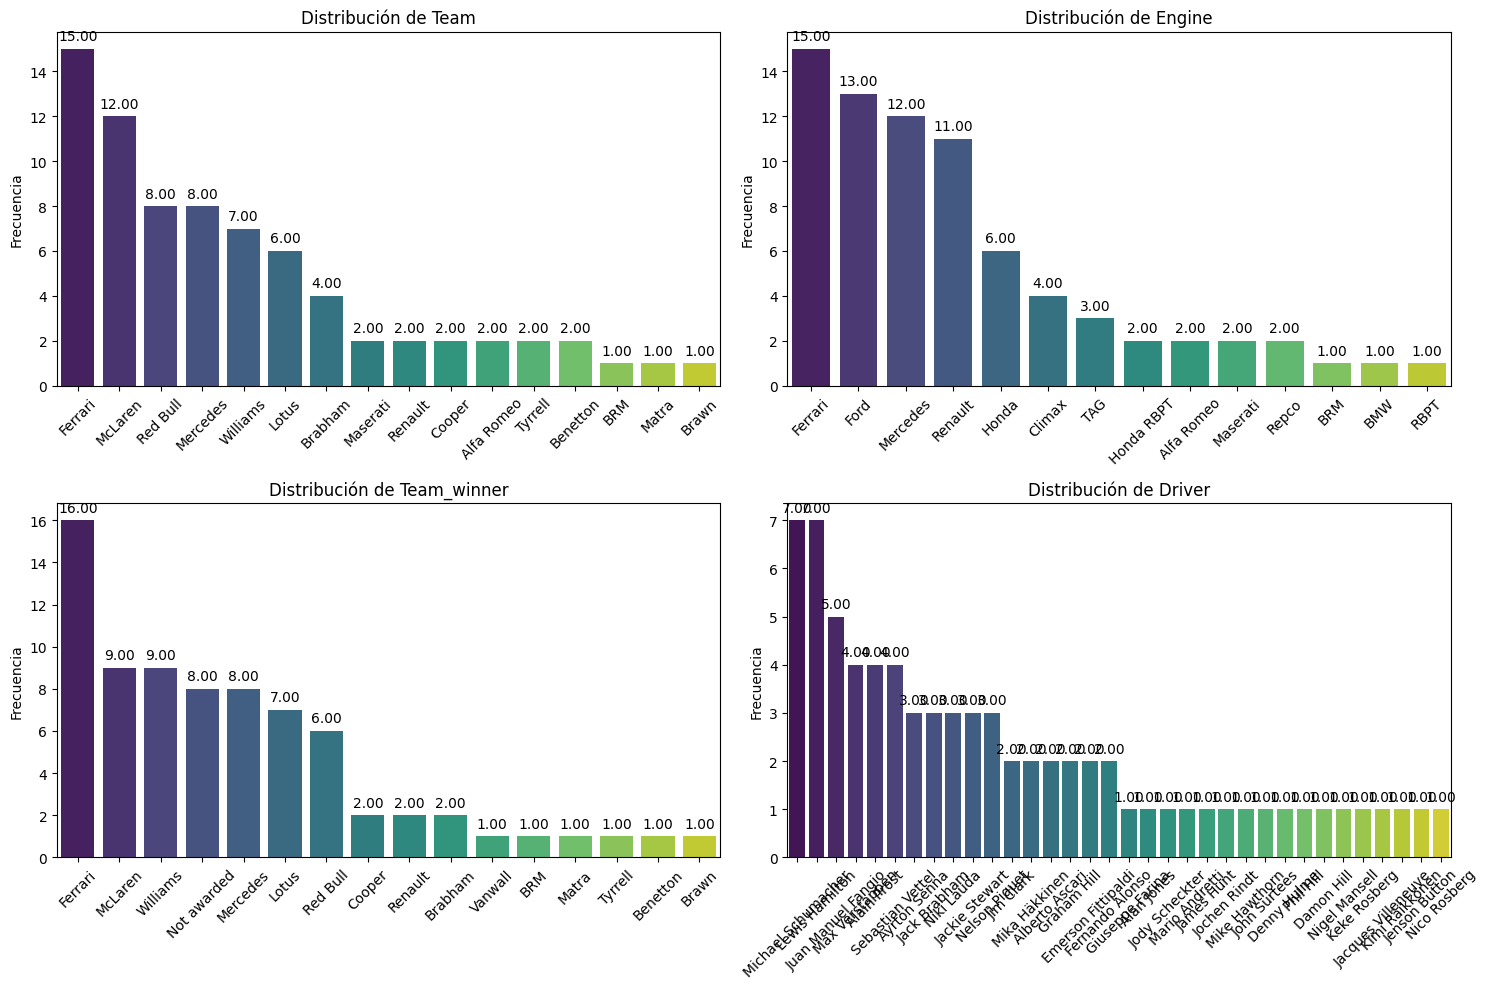

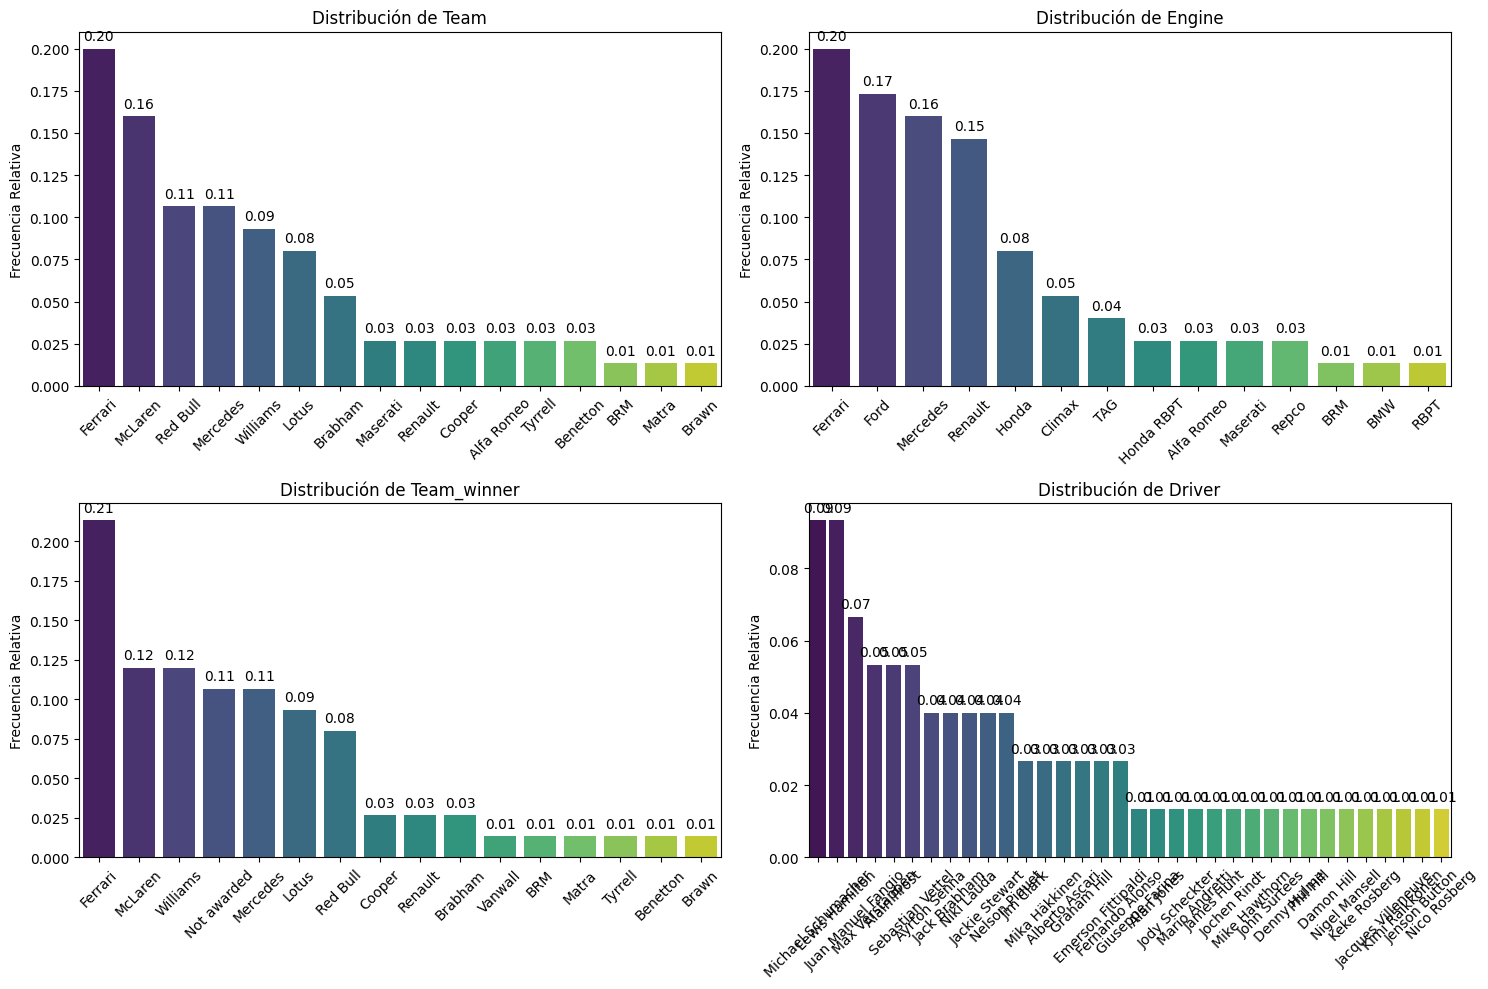

In [23]:
categoricas_temporadas = ["Team","Engine","Team_winner","Driver"]
pinta_distribucion_categoricas(df_temporadas_f1, categoricas_temporadas, mostrar_valores=True)
pinta_distribucion_categoricas(df_temporadas_f1, categoricas_temporadas, mostrar_valores=True, relativa=True)

En estos primeros gráficos se pueden ver datos interesantes. El equipo con la mayor cantidad de mundiales de equipos es `Ferrari`, con un total de 15. El equipo con la mayor cantidad de campeonatos de pilotos también es `Ferrari` con un total de 16 campeonatos. Los pilotos con la mayor cantidad de campeonatos del mundo son `Schumaches` y `Hamilton` con un total de 7 mundiales ambos.

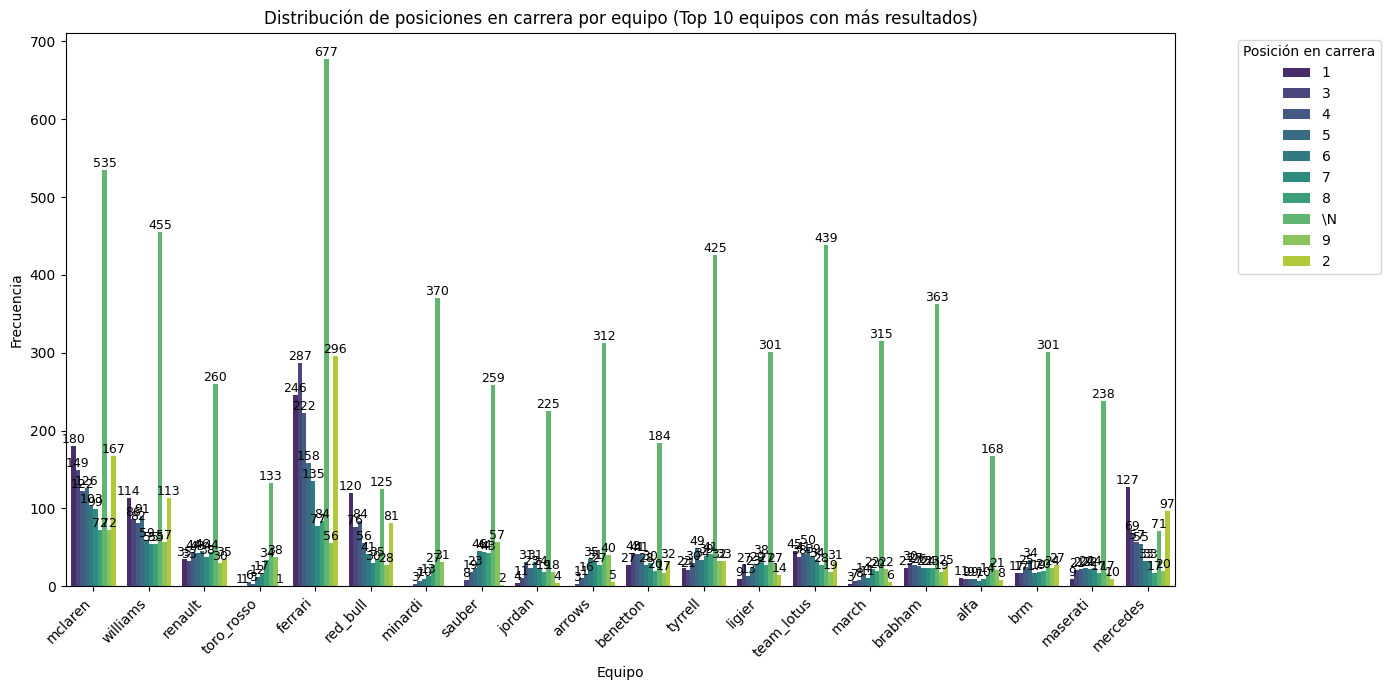

In [24]:
# Equipos con más resultados
top_equipos = df_combinado["team"].value_counts().head(20).index

# Filtrar los datos para incluir solo los equipos más exitosos y las posiciones del top 10
top_status = df_combinado["driver_race_position"].value_counts().head(10).index
df_filtrado = df_combinado[
    df_combinado["team"].isin(top_equipos) & 
    df_combinado["driver_race_position"].isin(top_status)
]

# Crear la gráfica
plt.figure(figsize=(14, 7))
ax = sns.countplot(
    data=df_filtrado,
    x="team",
    hue="driver_race_position",
    palette="viridis"
)

# Añadir valores a las barras
for container in ax.containers:
    ax.bar_label(container, label_type="edge", fontsize=9)

# Configuración de la gráfica
plt.title("Distribución de posiciones en carrera por equipo (Top 10 equipos con más resultados)")
plt.xlabel("Equipo")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Posición en carrera", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Mostrar la gráfica
plt.show()

En estas gráficas podemos observar la cantidad de veces que han quedado los equipos en cada posición, desde la primera posición hasta la 10ª. `Ferrari` es el equipo que más  victorias ha conseguido, con un total de 246 victorias. El segundo equipo con mayor cantidad de victorias es Mclaren, con un total de 180 victorias. El equipo con mayor cantidad de veces con posiciones inferiores a 9º es el equipo Ferrari, con un total de 677. Ferrari es un equipo que lleva en la Fórmula 1 desde los inicios mientras que Lotus ha estado en periodos de tiempo concretos, por lo que habría que ver de manera relativa cuántas carreras a quedado en una posición inferior a 9º.

Los siguientes gráficos muestran las posiciones de los 10 equipos principales en la F1 de manera relativa. No todos los equipos han estado durante la misma cantidad de carreras por lo que podemos ver sus resultados con respecto a las carreras en las que han participado


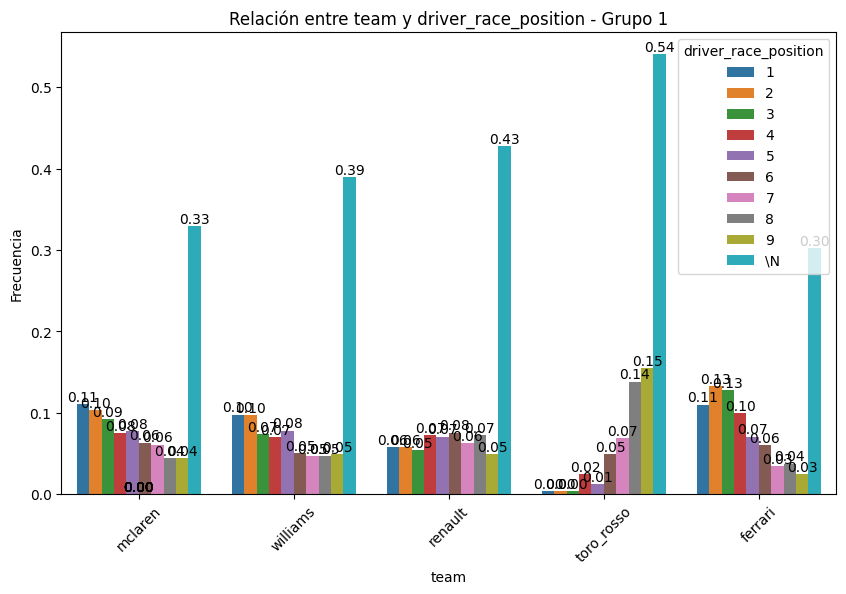

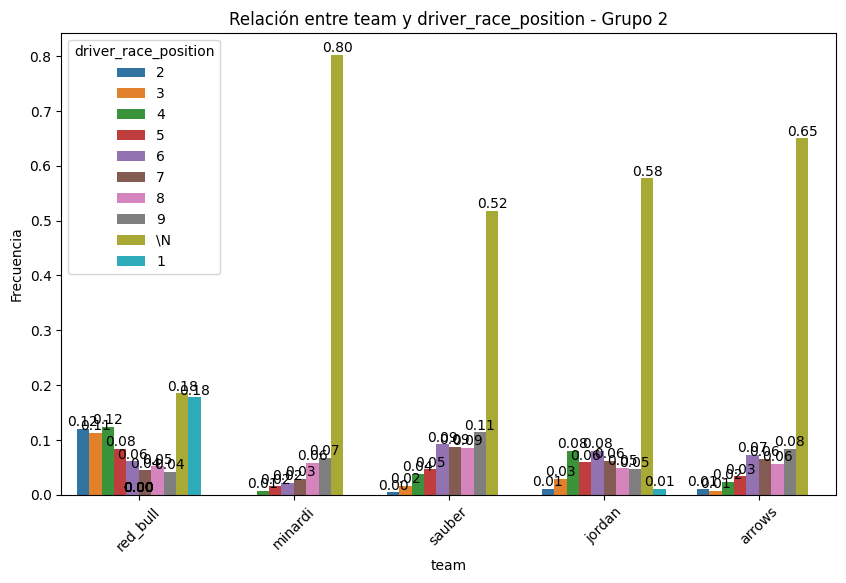

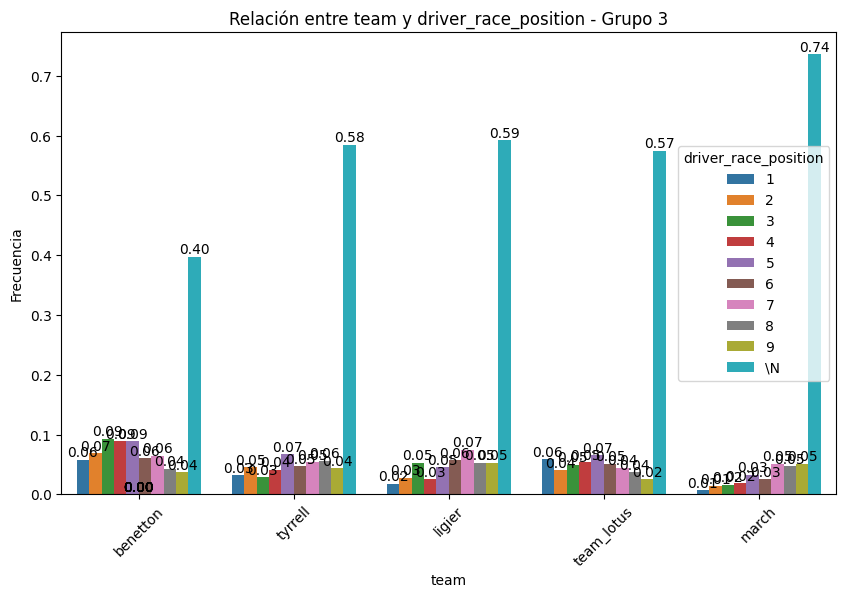

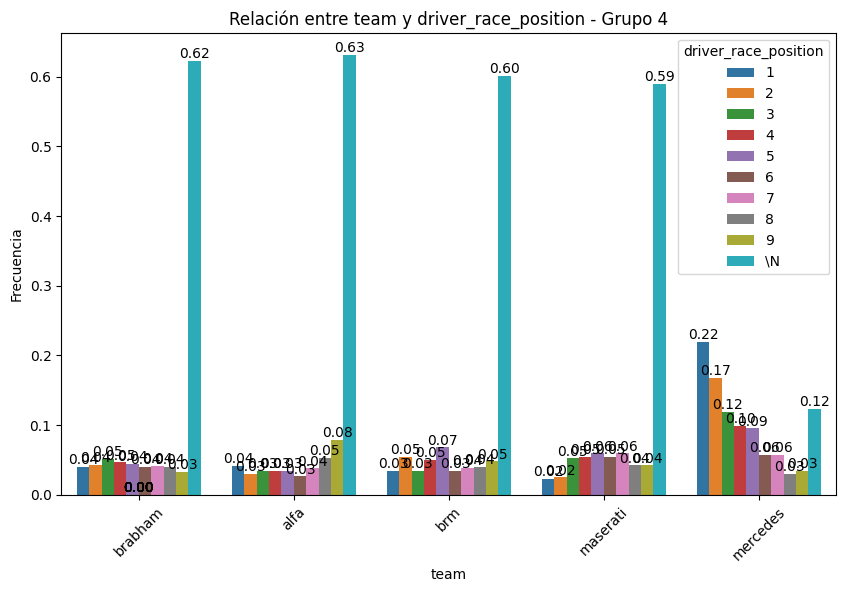

In [25]:
plot_categorical_relationship_fin(df_filtrado, "team", "driver_race_position", show_values=True, relative_freq=True)

Podemos observar que el equipo con la mayor cantidad de victorias es  `Mercedes`, con un 22% de todas las carreras en las que ha competido. El segundo equipo con la mayor cantidad de victorias es `Red Bull`, con un 18%. El equipo `Ferrari` pasa a ser tercero junto con `Mclaren`, ambos equipos con un 11%  de victorias. Esto nos muestra que el equipos como Mercerdes o Red Bull ha tenido un desempeño muy bueno durante el breve periodo de tiempo que lleva en la F1 en comparación con equipos más veteranos como son Ferrari o Mclaren. El equipo con la mayor cantidad de carreras por debajo de la 9ª posición es Minardi, con un 80% del total de las carreras en las que ha competido.

En la siguiente gráfica podemos observar los 10 status de carrera más comunes que han surgido en las carreras a lo largo de la F1. Esto nos sirve para saber si los coches de un equipo han terminado la carrera o si  han tenido algún tipo de fallo del motor, colisión durante la carrera, ha sido doblado por otro piloto, ...

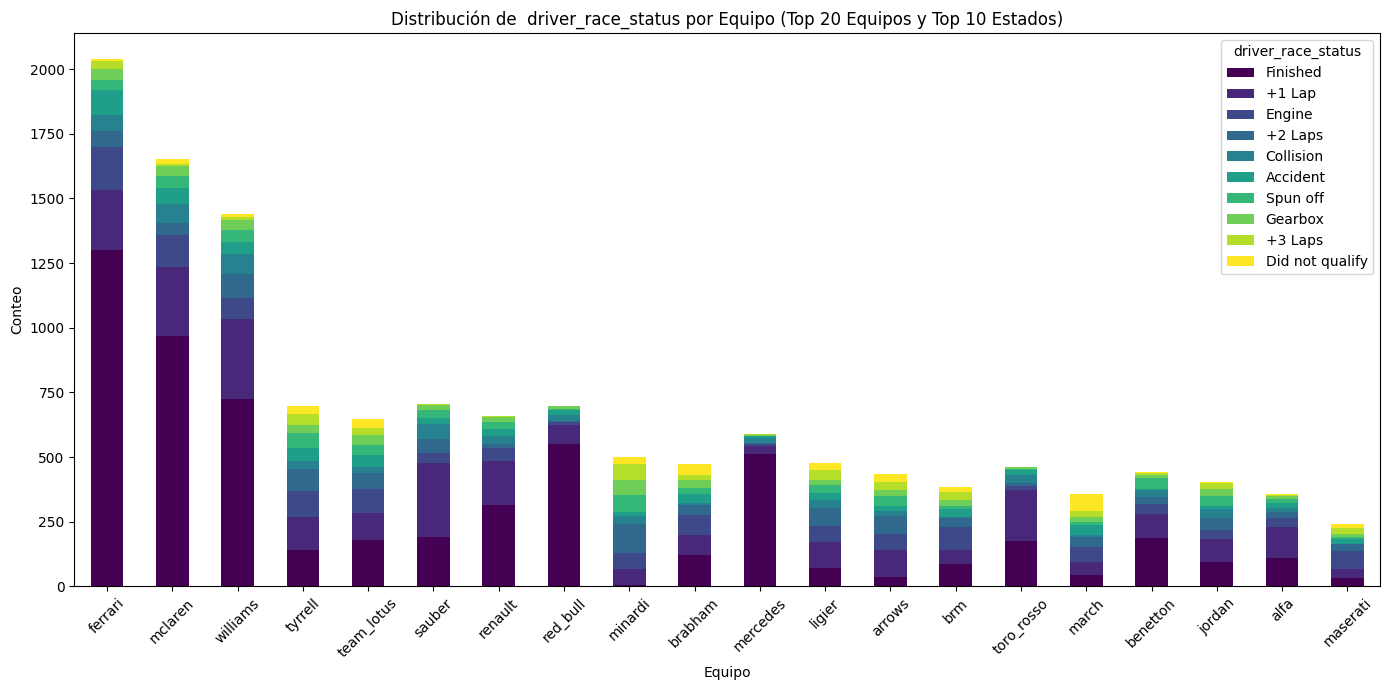

In [26]:
df_status_equipo = df_combinado.groupby(["team", "driver_race_status"]).size().unstack(fill_value=0)

# Seleccionar los 20 equipos con más entradas totales
top_20_teams = df_status_equipo.sum(axis=1).nlargest(20).index
df_status_equipo_top_20 = df_status_equipo.loc[top_20_teams]

# Seleccionar los 10 estados de driver_race_status más comunes
top_10_status = df_status_equipo_top_20.sum(axis=0).nlargest(10).index
df_status_equipo_top_20 = df_status_equipo_top_20[top_10_status]

# Crear la gráfica
df_status_equipo_top_20.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')

# Configurar la gráfica
plt.title("Distribución de  driver_race_status por Equipo (Top 20 Equipos y Top 10 Estados)")
plt.ylabel('Conteo')
plt.xlabel('Equipo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En la gráfica anterior se puede observar los resultados más frecuentes de los 20 equipos principales que han habido en la F1. Los que destacan por el resultado `Finished` son `Ferrari`, `Mclaren`,`Williams`,`Red Bull` y `Mercedes`. Este resultado en carrera nos indica que el piloto del equipo ha podido terminar la carrera y no ha abandonado, lo que sugiere que el coche tiene una alta fiabilidad como para terminar la carrera.

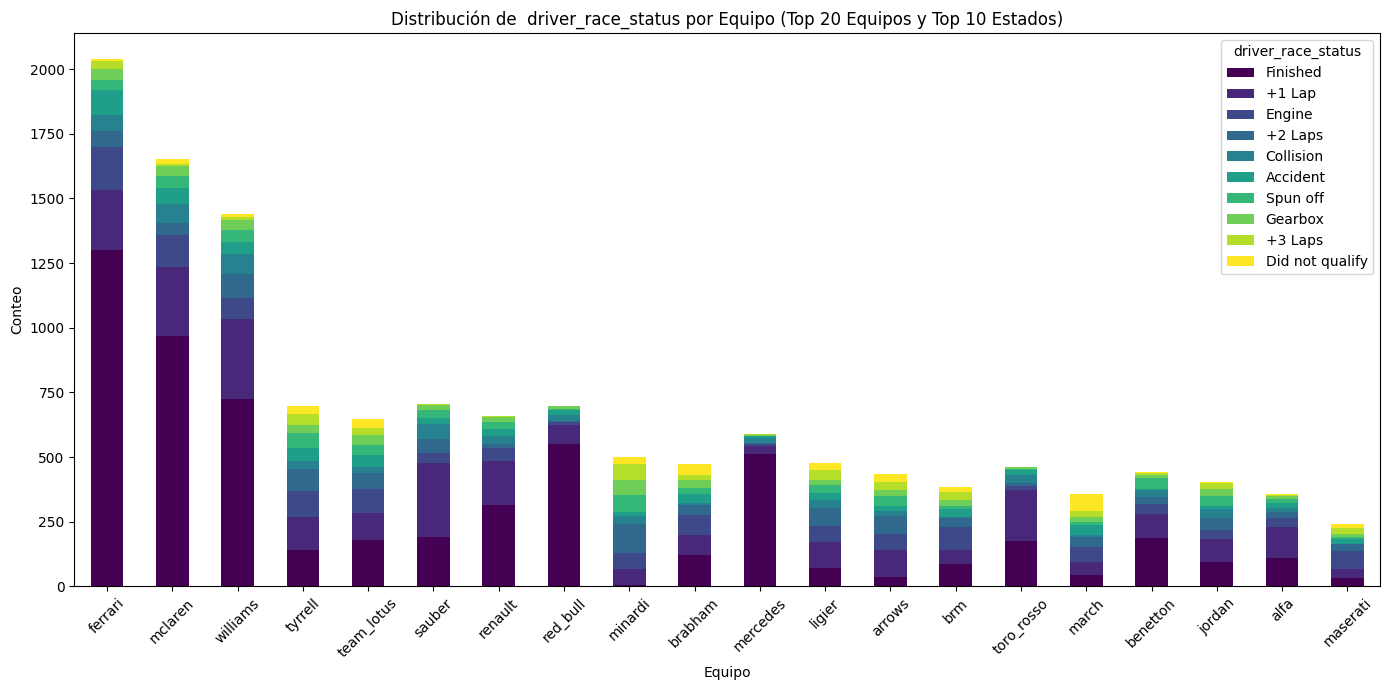

In [27]:
df_status_equipo = df_combinado.groupby(["team", "driver_race_status"]).size().unstack(fill_value=0)

# Seleccionar los 20 equipos con más entradas totales
top_20_teams = df_status_equipo.sum(axis=1).nlargest(20).index
df_status_equipo_top_20 = df_status_equipo.loc[top_20_teams]

# Seleccionar los 10 estados de driver_race_status más comunes
top_10_status = df_status_equipo_top_20.sum(axis=0).nlargest(10).index
df_status_equipo_top_20 = df_status_equipo_top_20[top_10_status]

# Crear la gráfica
df_status_equipo_top_20.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')

# Configurar la gráfica
plt.title("Distribución de  driver_race_status por Equipo (Top 20 Equipos y Top 10 Estados)")
plt.ylabel('Conteo')
plt.xlabel('Equipo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

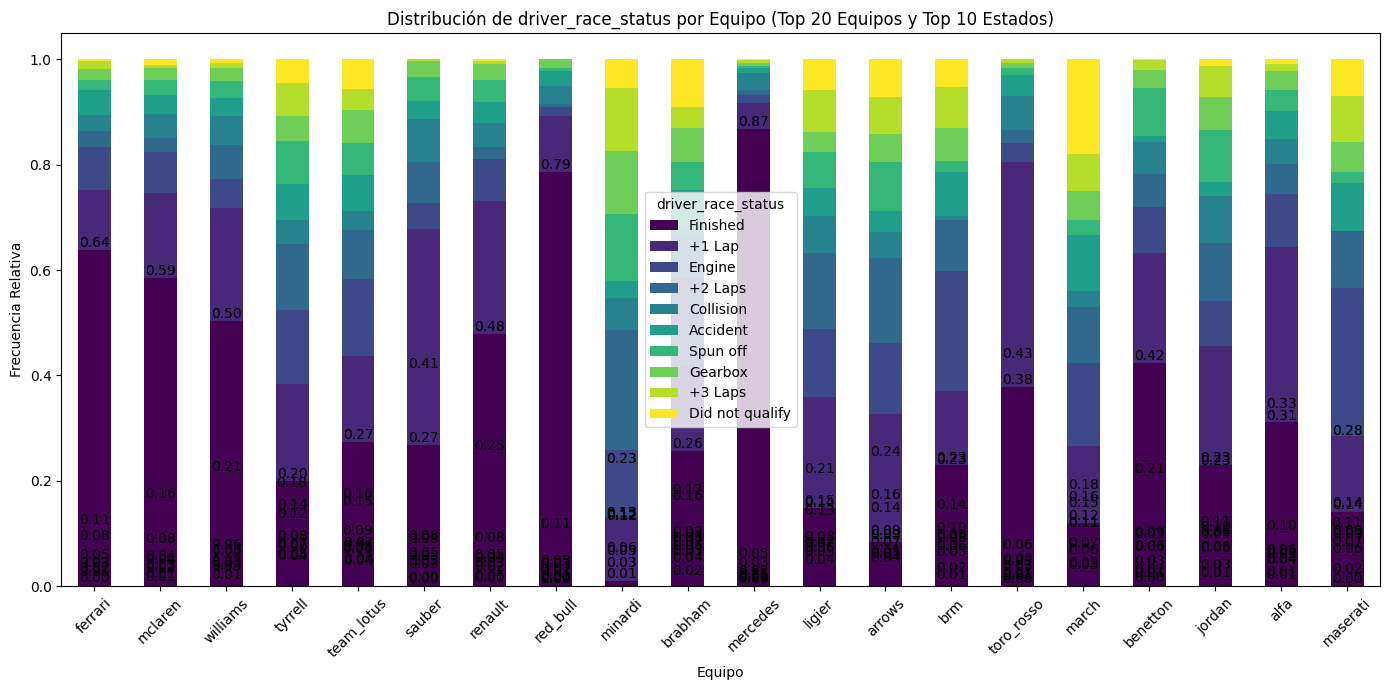

In [28]:
df_status_equipo = df_combinado.groupby(["team", "driver_race_status"]).size().unstack(fill_value=0)

# Seleccionar los 20 equipos con más entradas totales
top_20_teams = df_status_equipo.sum(axis=1).nlargest(20).index
df_status_equipo_top_20 = df_status_equipo.loc[top_20_teams]

# Seleccionar los 10 estados de driver_race_status más comunes
top_10_status = df_status_equipo_top_20.sum(axis=0).nlargest(10).index
df_status_equipo_top_20 = df_status_equipo_top_20[top_10_status]

# Calcular las frecuencias relativas
df_status_equipo_top_20_relative = df_status_equipo_top_20.div(df_status_equipo_top_20.sum(axis=1), axis=0)

# Crear la gráfica
ax = df_status_equipo_top_20_relative.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')

# Mostrar los valores en cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Configurar la gráfica
plt.title("Distribución de driver_race_status por Equipo (Top 20 Equipos y Top 10 Estados)")
plt.ylabel('Frecuencia Relativa')
plt.xlabel('Equipo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En el gráfico anterior podemos observar de manera relativa el estado del piloto en carrera por equipo. El equipo con la mayor cantidad de `Finished` es `Mercedes` con un 87%, seguido de `Red Bull` con un 79%, `Ferrari` con 64%, `Mclaren` con 59% y `Williams` con 50%. Esto nos indica que han sabido desarrollar un coche con una gran fiabilidad ya que han terminado la mayoría de las carreras en las que han competido.

Ahora vamos a analizar las victorias que han conseguido los pilotos para ver en qué equipos han conseguido dichas victorias.

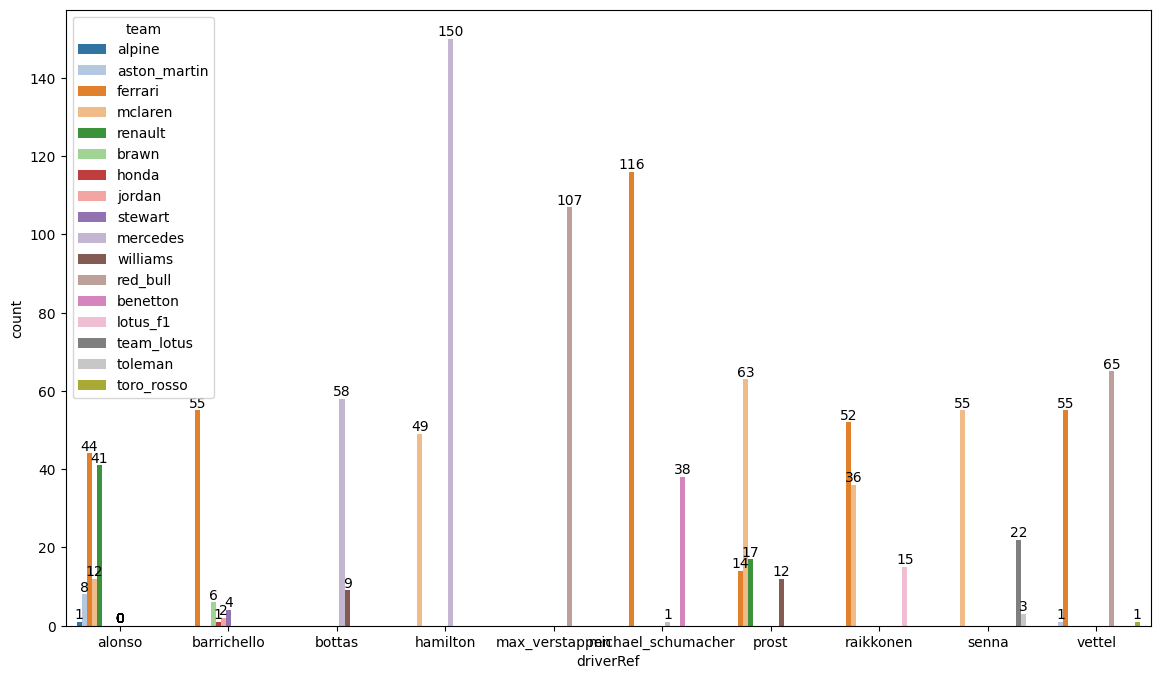

In [ ]:
# Filtrar los resultados en los que los pilotos han quedado en el podio (1º, 2º, 3º)
top_resultados_pilotos = df_combinado[df_combinado["driver_race_position"].isin(["1", "2", "3"])]

# Agrupar por piloto y equipo, y contar los resultados
resultados_por_piloto_equipo = (
    top_resultados_pilotos.groupby(["driverRef", "team"])
    .size()
    .reset_index(name="count")
)

# Agrupar por piloto para encontrar la cantidad total de resultados top (sin importar el equipo)
resultados_por_piloto = (
    resultados_por_piloto_equipo.groupby("driverRef")["count"]
    .sum()
    .reset_index()
    .sort_values(by="count", ascending=False)
)

# Seleccionar los pilotos con más resultados top (por ejemplo, los 10 mejores)
top_10_pilotos = resultados_por_piloto.head(10)

# Filtrar los resultados por los pilotos seleccionados
resultados_filtrados = resultados_por_piloto_equipo[resultados_por_piloto_equipo["driverRef"].isin(top_10_pilotos["driverRef"])]

# Crear la gráfica
plt.figure(figsize=(14, 8))  # Aumenté el tamaño de la figura para dar más espacio
ax = sns.barplot(
    data=resultados_filtrados,
    x="driverRef",
    y="count",
    hue="team",
    palette="tab20",
)

# Agregar las etiquetas con los valores de cada barra
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # El valor que se va a mostrar en la barra
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posición de la etiqueta
        ha='center', va='center',  # Alineación de la etiqueta
        fontsize=10, color='black',  # Estilo de la etiqueta
        xytext=(0, 5),  # Desplazamiento de la etiqueta
        textcoords='offset points'
    )

En el gráfico anterior podemos observar la cantidad de podios que ha conseguido cada piloto agrupados por equipo. Se observa que hay una gran cantidad de podios de `Ferrari`. Además destaca los podios obtenidos por parte de los pilotos que corrían para `Mercedes`, donde Hamilton obtuvo un total de 150 podios y Bottas 58 podios.
Hay algunos pilotos que han conseguido buenos resultados en equipos que no han obtenido ningún mundial, como puede ser Alonso con: 1 podio con `Alpine` y 8 con `Aston Martin`, Barrichello: 4 con `Stewart`, 1 con `Honda`.

En la siguiente gráfica se analiza el total de resultados en el top 3 que han conseguido los equipos de F1. Los resultados están divididos entre las victorias y los resultados de podio (2º y 3er puesto).

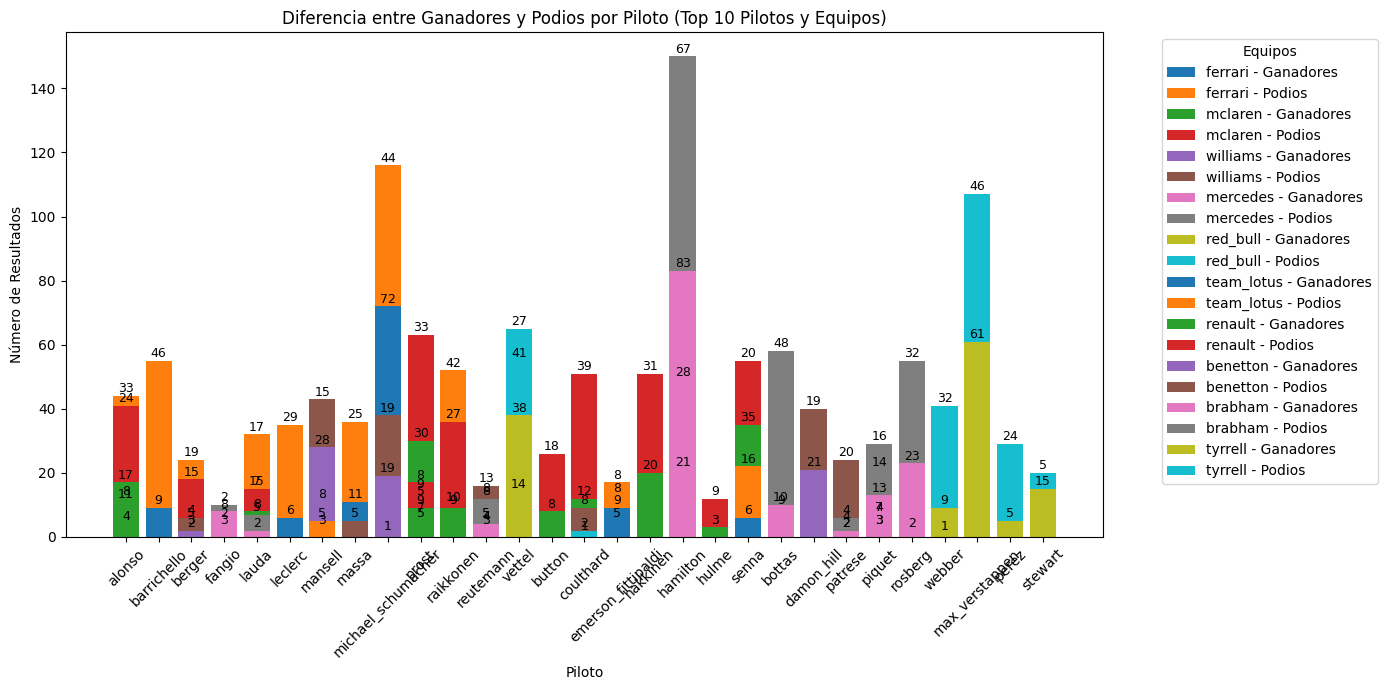

In [32]:
# Filtrar los datos de ganadores y podio
df_ganadores = df_combinado[df_combinado["driver_race_position"] == "1"]
df_podio = df_combinado[df_combinado["driver_race_position"].isin(["2", "3"])]

# Agrupar por piloto y equipo, y contar las ocurrencias
ganadores_por_piloto = df_ganadores.groupby(["driverRef", "team"]).size().reset_index(name="Ganadores")
podio_por_piloto = df_podio.groupby(["driverRef", "team"]).size().reset_index(name="Podios")

# Combinar ambos resultados en un DataFrame
df_resultados = pd.merge(
    ganadores_por_piloto,
    podio_por_piloto,
    on=["driverRef", "team"],
    how="outer"
).fillna(0)

# Calcular el total de buenos resultados por piloto
df_resultados["Total"] = df_resultados["Ganadores"] + df_resultados["Podios"]

# Filtrar los 10 pilotos con más buenos resultados
top_10_pilotos = df_resultados.groupby("driverRef")["Total"].sum().nlargest(30).index
df_resultados_top_10 = df_resultados[df_resultados["driverRef"].isin(top_10_pilotos)]

# Filtrar los 10 equipos con más buenos resultados
top_10_equipos = df_resultados.groupby("team")["Total"].sum().nlargest(10).index
df_resultados_top_10 = df_resultados_top_10[df_resultados_top_10["team"].isin(top_10_equipos)]

# Crear gráfica
plt.figure(figsize=(14, 7))

for equipo in top_10_equipos:
    datos_equipo = df_resultados_top_10[df_resultados_top_10["team"] == equipo]
    barras_ganadores = plt.bar(
        datos_equipo["driverRef"],
        datos_equipo["Ganadores"],
        label=f"{equipo} - Ganadores"
    )
    barras_podios = plt.bar(
        datos_equipo["driverRef"],
        datos_equipo["Podios"],
        bottom=datos_equipo["Ganadores"],
        label=f"{equipo} - Podios"
    )

    # Añadir valores a las barras de ganadores
    for barra in barras_ganadores:
        altura = barra.get_height()
        if altura > 0:
            plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.2, f'{int(altura)}', 
                     ha='center', va='bottom', fontsize=9)

    # Añadir valores a las barras de podios
    for barra in barras_podios:
        altura = barra.get_height()
        if altura > 0:
            plt.text(barra.get_x() + barra.get_width() / 2, barra.get_y() + altura + 0.2, f'{int(altura)}', 
                     ha='center', va='bottom', fontsize=9)

# Configuración del gráfico
plt.title("Diferencia entre Ganadores y Podios por Piloto (Top 10 Pilotos y Equipos)")
plt.xlabel("Piloto")
plt.ylabel("Número de Resultados")
plt.xticks(rotation=45)
plt.legend(title="Equipos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


F-stat: 43.104866644596775
P-Value: 0.0
Rechazamos la hipótesis nula: Hay diferencias significativas entre los equipos.


C:\Users\usuar\AppData\Local\Temp\ipykernel_2192\3326914682.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='team', y='positionOrder', data=df_combinado, palette='viridis')


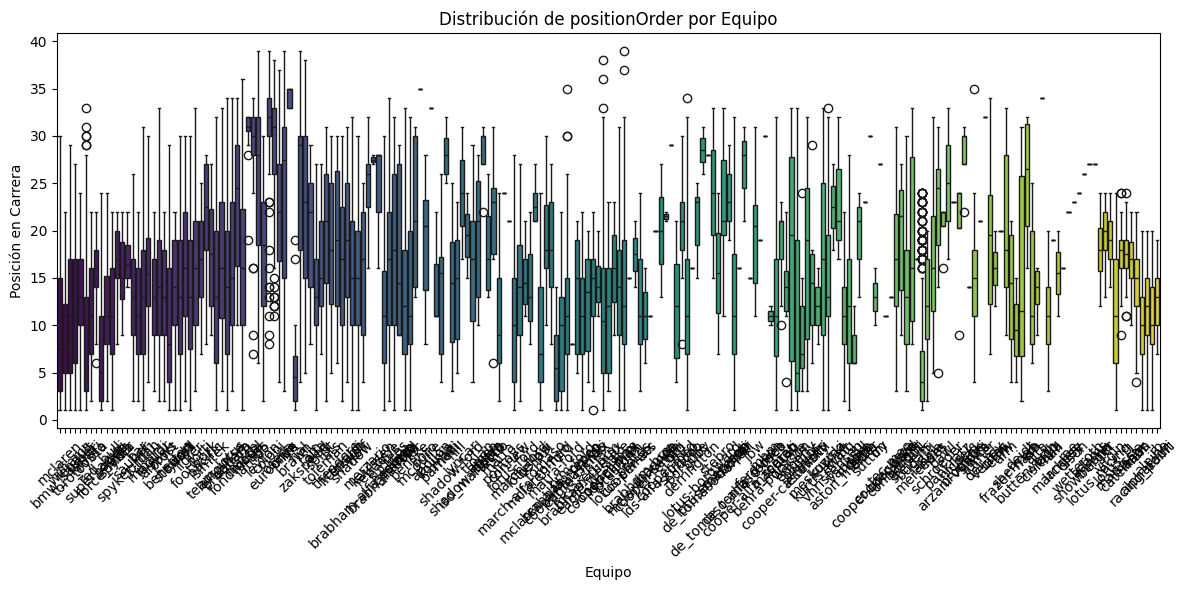

In [33]:
#ANOVA
teams = df_combinado['team'].unique()
groups = [df_combinado[df_combinado['team'] == team]['positionOrder'] for team in teams]

f_stat, p_value = stats.f_oneway(*groups)

print(f"F-stat: {f_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: Hay diferencias significativas entre los equipos.")
else:
    print("No se rechaza la hipótesis nula: No hay evidencia de diferencias significativas entre los equipos.")

# Visualización
plt.figure(figsize=(12, 6))
sns.boxplot(x='team', y='positionOrder', data=df_combinado, palette='viridis')
plt.xticks(rotation=45)
plt.title('Distribución de positionOrder por Equipo')
plt.ylabel('Posición en Carrera')
plt.xlabel('Equipo')
plt.tight_layout()
plt.show()

Podemos afirmar que hay una relación significativa entre los resultados de los pilotos en carrera y el equipo para el que compiten.